# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [8]:
import os
import pandas as pd
import numpy as np
import math
import json
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from time import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings('ignore')

In [9]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 0. EDA

In [13]:
portfolio.shape

(10, 6)

In [11]:
profile.shape

(17000, 5)

In [12]:
transcript.shape

(306534, 4)

In [17]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [18]:
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [19]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [20]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [21]:
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [24]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [26]:
profile.duplicated().sum()

0

In [28]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


## 1. Data Preprocessing

### Cleaning Transcript Data

In [30]:
# renaming column to avoid any confusion later on
transcript.rename(columns = {'person': 'customer_id'}, inplace = True)

In [31]:
# Seperate 'value' column into 3 new columns: amount, order_id, and rewards
key_list = []
for i in range(len(transcript.value)):
    if (transcript.value[i].keys()) not in key_list:
        key_list.append(transcript.value[i].keys())
key_list

[dict_keys(['offer id']),
 dict_keys(['amount']),
 dict_keys(['offer_id', 'reward'])]

In [33]:
# function for creating new columns
def create_rewards_col(df):
    """
    Get the reward details against each customer id as a separate column from an existing column
    
    Input: Dataframe with the desired column to be worked upon
    
    Output: list of reward details against an id
    """
    rewards_list = []
    for i in range(len(df.value)):
            rewards_list.append(df.value[i].get('rewards'))
    return rewards_list

def create_amount_col(df):
    """
    Get the amount details against each customer id as a separate column from an existing column
    
    Input: Dataframe with the desired column to be worked upon
    
    Output: list of amount details against an id
    """
    amount_list = []
    for i in range(len(df.value)):
            amount_list.append(df.value[i].get('amount'))
    return amount_list

def create_offer_id_col(df):
    """
    Get the offer details against each customer id as a separate column from an existing column
    
    Input: Dataframe with the desired column to be worked upon
    
    Output: list of reward details against an id
    """
    order_id_list = []
    keys_to_lookup = ['offer id', 'offer_id']

    for i in range(len(df.value)):
        if keys_to_lookup[0] in df.value[i]:
            order_id_list.append(df.value[i].get(keys_to_lookup[0]))
        elif keys_to_lookup[1] in df.value[i]:
            order_id_list.append(df.value[i].get(keys_to_lookup[1]))
        else:
            order_id_list.append(np.nan)
    return order_id_list

In [34]:
transcript['rewards'] = create_rewards_col(transcript)
transcript['amount'] = create_amount_col(transcript)
transcript['offer_id'] = create_offer_id_col(transcript)

transcript.head()

,customer_id,event,value,time,rewards,amount,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,None,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,None,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,None,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,None,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,None,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [35]:
# before, we clean take a look at the rewards column
# it's full of nulls! So, we should remove it
transcript.rewards.isnull().sum()

306534

In [36]:
transcript.drop(columns = ['value', 'rewards'], inplace = True)
transcript.head()

,customer_id,event,time,amount,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [37]:
#convert ammount to float
transcript.amount.astype('float')
transcript.amount.dtype

dtype('float64')

In [38]:
# Drop all rows from transcript where 'customer_id' not in profile.id .
transcript = transcript[transcript.customer_id.isin(profile.id)] # no rows were dropped

In [39]:
# convert time from hours to days 
transcript.time /= 24
transcript.tail()

,customer_id,event,time,amount,offer_id
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,29.75,1.59,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,29.75,9.53,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,29.75,3.61,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,29.75,3.53,NaN
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,29.75,4.05,NaN


In [40]:
#Split event column into 4 columns: 'offer_received', 'offer_viewed', 'offer_completed' and 'transaction'
transcript['offer_received'] = transcript['event'].apply(lambda x: 1 if x == 'offer received' else 0)
transcript['offer_viewed'] = transcript['event'].apply(lambda x: 1 if x == 'offer viewed' else 0)
transcript['offer_completed'] = transcript['event'].apply(lambda x: 1 if x == 'offer completed' else 0)
transcript['transaction'] = transcript['event'].apply(lambda x: 1 if x == 'transaction' else 0)

# drop event column
transcript.drop(columns = ['event'], inplace = True)
# check
transcript.head(1)

,customer_id,time,amount,offer_id,offer_received,offer_viewed,offer_completed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0


In [41]:
transcript.duplicated().sum() # there are a total of 2962 duplicate rows
transcript.drop_duplicates(inplace = True)

#check
transcript.duplicated().sum()

0

### Cleaning Profile Data

In [42]:
profile.age = profile.age.replace(118, np.nan)

In [43]:
# Convert became_member_on to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile.head()

,gender,age,id,became_member_on,income
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [44]:
# rename id column to customer_id
profile.rename(columns = {'id': 'customer_id'}, inplace = True)

#Check
profile.head(1)

,gender,age,customer_id,became_member_on,income
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN


### Cleaning Portfolio Data

In [45]:
# rename id to order_id
portfolio.rename(columns = {'id': 'offer_id'}, inplace = True)

In [46]:
# Split 'channels' column into 4 columns: 'web', 'mobile', 'email' and 'social'
portfolio['web'] = portfolio.channels.apply(lambda x: 1 if 'web' in x else 0)
portfolio['mobile'] = portfolio.channels.apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['email'] = portfolio.channels.apply(lambda x: 1 if 'email' in x else 0)
portfolio['social'] = portfolio.channels.apply(lambda x: 1 if 'social' in x else 0)

# drop channels column
portfolio.drop(columns = ['channels'], inplace = True)

#check 
portfolio.head(1)

,reward,difficulty,duration,offer_type,offer_id,web,mobile,email,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1


In [47]:
# Merge transcript and portfolio data
transcript_portfolio = transcript.merge(portfolio, how = 'left', on = 'offer_id')
transcript_portfolio

,customer_id,time,amount,offer_id,offer_received,offer_viewed,offer_completed,transaction,reward,difficulty,duration,offer_type,web,mobile,email,social
0,78afa995795e4d85b5d9ceeca43f5fef,0.00,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,0.00,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,0,5.0,20.0,10.0,discount,1.0,0.0,1.0,0.0
2,e2127556f4f64592b11af22de27a7932,0.00,NaN,2906b810c7d4411798c6938adc9daaa5,1,0,0,0,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0.00,NaN,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,0,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,0.00,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306132,b3a1272bc9904337b331bf348c3e8c17,29.75,1.59,NaN,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306133,68213b08d99a4ae1b0dcb72aebd9aa35,29.75,9.53,NaN,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306134,a00058cf10334a308c68e7631c529907,29.75,3.61,NaN,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306135,76ddbd6576844afe811f1a3c0fbb5bec,29.75,3.53,NaN,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Data Visualizations

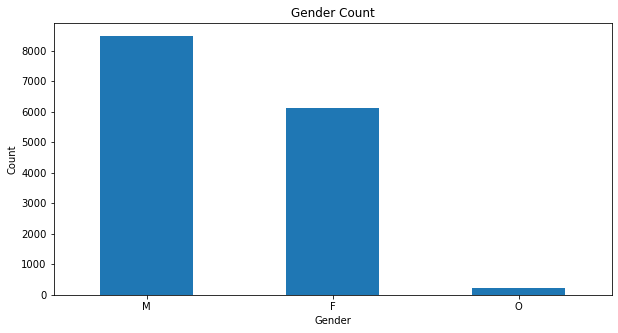

In [49]:
# Gender count
fig = plt.figure(figsize = (10,5))
ax = profile.gender.value_counts().plot(kind = 'bar')

plt.xticks(rotation = 360)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Count');

From the identity collected of customers, over 8000 users identified themselves as Males

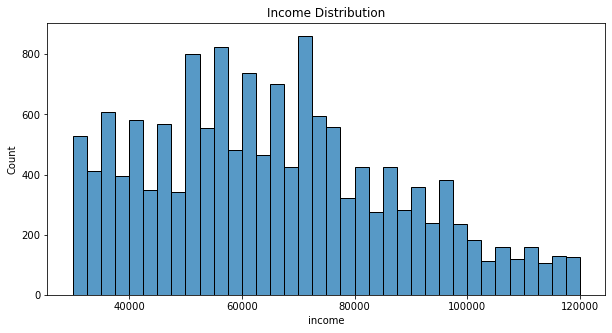

In [50]:
# income distribution
fig = plt.figure(figsize = (10,5))
sb.histplot(data = profile, x = 'income')
plt.title('Income Distribution');

The income is skewed to the right a little bit.

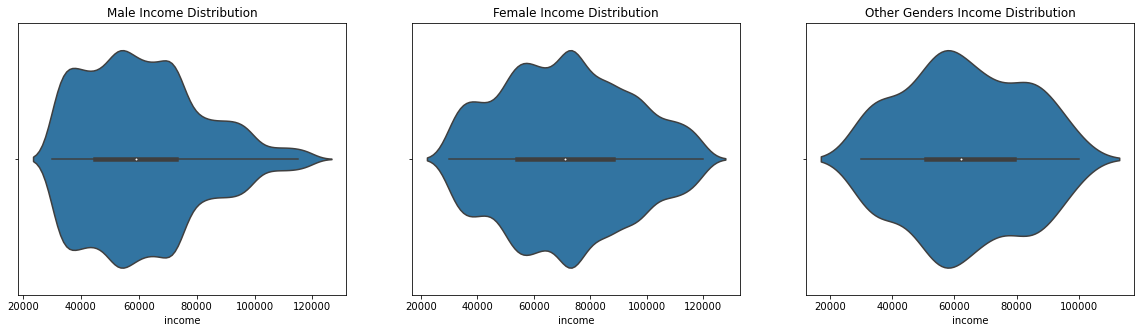

In [51]:
# Gender wise income distribution
fig, ax = plt.subplots(1, 3, figsize = [20, 5])
ax1 = sb.violinplot(profile.query('gender == "M"')['income'], ax = ax[0])
ax1.title.set_text('Male Income Distribution');
ax2 = sb.violinplot(profile.query('gender == "F"')['income'], ax = ax[1])
ax2.title.set_text('Female Income Distribution');
ax3 = sb.violinplot(profile.query('gender == "O"')['income'], ax = ax[2])
ax3.title.set_text('Other Genders Income Distribution');

- The income seems evenly distributed for every gender except fot the males. 
- We can see that the majority of male members have income less than $80,000.

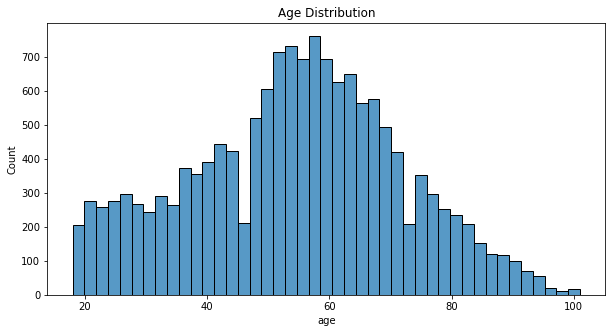

In [52]:
# Age distribution
fig = plt.figure(figsize = (10,5))
sb.histplot(data = profile, x = 'age')
plt.title('Age Distribution');

The age seems to be pretty normally distributed. Near the end it begins to taper off which makes sense since it's very rare to come across some one who is older than 90

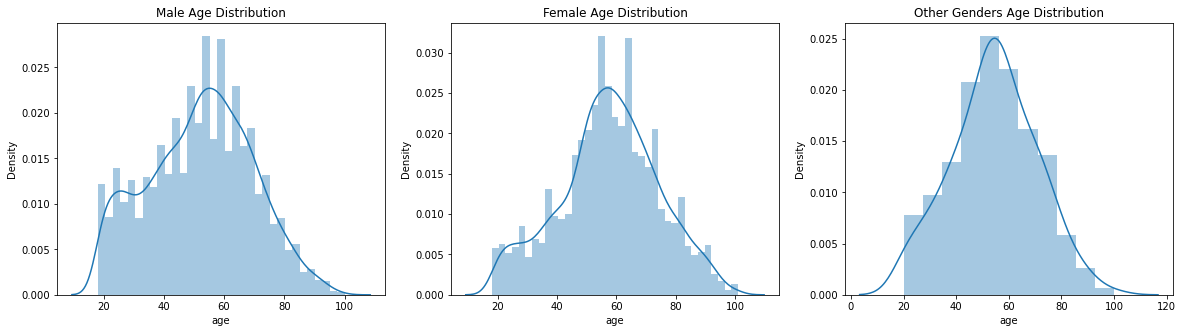

In [53]:
# Gender based Age distribution
fig, ax = plt.subplots(1, 3, figsize = [20, 5])
ax1 = sb.distplot(profile.query('gender == "M"')['age'], ax = ax[0])
ax1.title.set_text('Male Age Distribution');
ax2 = sb.distplot(profile.query('gender == "F"')['age'], ax = ax[1])
ax2.title.set_text('Female Age Distribution');
ax3 = sb.distplot(profile.query('gender == "O"')['age'], ax = ax[2])
ax3.title.set_text('Other Genders Age Distribution');

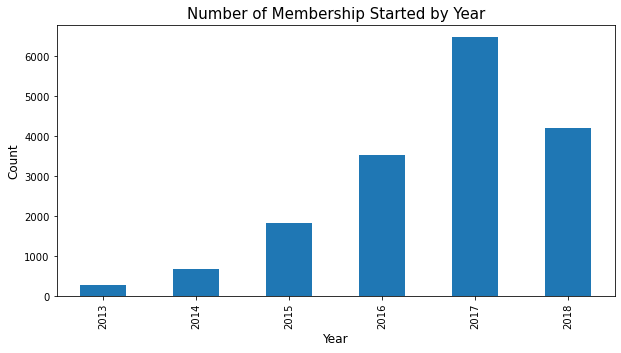

In [54]:
# Membership by year
fig = plt.figure(figsize = (10,5))
ax = profile['became_member_on'].groupby(profile['became_member_on'].dt.year).count().plot(kind = 'bar')
plt.title('Number of Membership Started by Year', fontsize = 15)
plt.xlabel('Year', fontsize = 12)
plt.ylabel('Count', fontsize = 12);

2017 saw a huge spike in customer acquisitions, but the year 2018 has seen this number go down which seems pretty intriguing

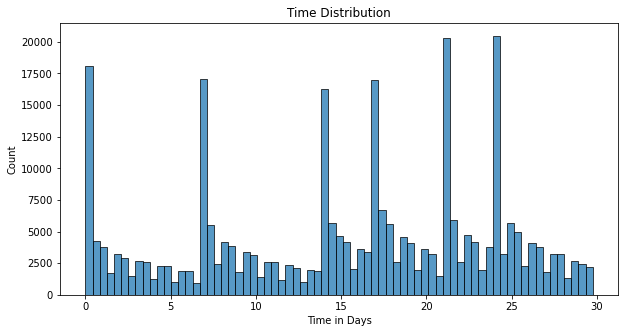

In [55]:
# Membership by Day of Month
fig = plt.figure(figsize = (10,5))
sb.histplot(data = transcript_portfolio, x = 'time')
plt.title('Time Distribution')
plt.xlabel("Time in Days");

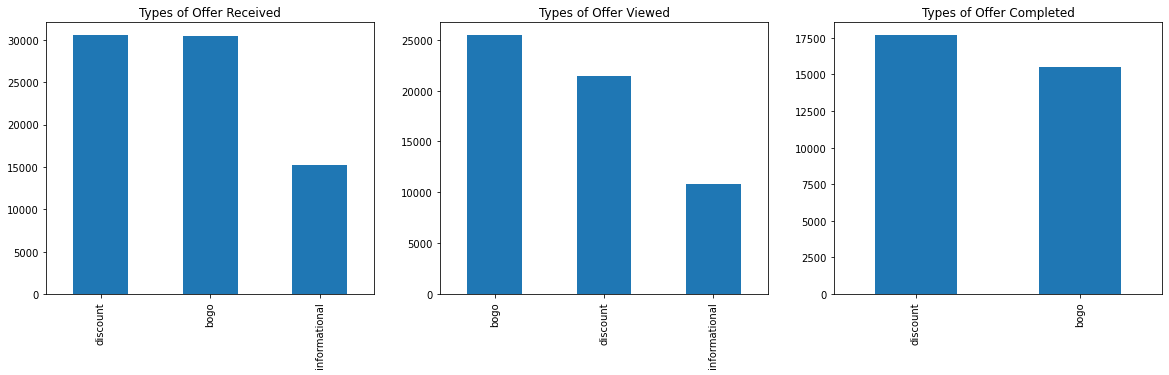

In [56]:
# Offer based
fig, ax = plt.subplots(1, 3, figsize = [20, 5])
ax1 = transcript_portfolio[transcript_portfolio.offer_received == 1].offer_type.value_counts().plot(kind = 'bar', 
                                                                                                   ax = ax[0])
ax1.title.set_text('Types of Offer Received');

ax2 = transcript_portfolio[transcript_portfolio.offer_viewed == 1].offer_type.value_counts().plot(kind = 'bar',
                                                                                                 ax = ax[1])
ax2.title.set_text('Types of Offer Viewed');

ax3 = transcript_portfolio[transcript_portfolio.offer_completed == 1].offer_type.value_counts().plot(kind = 'bar',
                                                                                                 ax = ax[2])
ax3.title.set_text('Types of Offer Completed');

Beginning with the 1st bar plot on the left, we can see that a members have received the same amount of discount and bogo("buy one, get one"). When we look at the second graph, we can see that more people have viewed the bogo offer which might means that it's more attractive. 

## 3. Data Preprocessing  for Modeling

In [62]:
#Merge transcipt_portfolio with profile
df_master = transcript_portfolio.merge(profile, how = 'inner', on = 'customer_id')
df_master.head()

,customer_id,time,amount,offer_id,offer_received,offer_viewed,offer_completed,transaction,reward,difficulty,duration,offer_type,web,mobile,email,social,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,0.00,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,F,75.0,2017-05-09,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,0.25,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,F,75.0,2017-05-09,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,5.50,19.89,NaN,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,75.0,2017-05-09,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,5.50,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,F,75.0,2017-05-09,100000.0
4,78afa995795e4d85b5d9ceeca43f5fef,6.00,17.78,NaN,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,75.0,2017-05-09,100000.0


In [63]:
# From became_member_on create join_year
df_master['join_year'] = df_master['became_member_on'].dt.year

#check
df_master.head()

,customer_id,time,amount,offer_id,offer_received,offer_viewed,offer_completed,transaction,reward,difficulty,...,offer_type,web,mobile,email,social,gender,age,became_member_on,income,join_year
0,78afa995795e4d85b5d9ceeca43f5fef,0.00,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,5.0,5.0,...,bogo,1.0,1.0,1.0,0.0,F,75.0,2017-05-09,100000.0,2017
1,78afa995795e4d85b5d9ceeca43f5fef,0.25,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,5.0,5.0,...,bogo,1.0,1.0,1.0,0.0,F,75.0,2017-05-09,100000.0,2017
2,78afa995795e4d85b5d9ceeca43f5fef,5.50,19.89,NaN,0,0,0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,F,75.0,2017-05-09,100000.0,2017
3,78afa995795e4d85b5d9ceeca43f5fef,5.50,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,0,5.0,5.0,...,bogo,1.0,1.0,1.0,0.0,F,75.0,2017-05-09,100000.0,2017
4,78afa995795e4d85b5d9ceeca43f5fef,6.00,17.78,NaN,0,0,0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,F,75.0,2017-05-09,100000.0,2017


In [64]:
df_master['join_year'].isnull().sum()

0

In [65]:
# encode gender
df_master['gender'] = df_master.gender.apply(lambda x: 1 if x == 'F' else 2 if (x=='M')\
                                                             else 3 if x == 'O' else np.nan)
df_master['gender'].unique()

array([ 1., nan,  2.,  3.])

In [66]:
# select relevant features for modeling
df_master = df_master[['time', 'amount', 'offer_completed', 'reward', 
                       'difficulty', 'age', 'income', 'gender', 'join_year']]

In [67]:
# drop records with income values as null 
df_master.dropna(subset=['income'], inplace = True)

In [68]:
# fill nulls with 0
df_master.fillna(0, inplace = True)

In [69]:
df_master.isnull().sum()

time               0
amount             0
offer_completed    0
reward             0
difficulty         0
age                0
income             0
gender             0
join_year          0
dtype: int64

## 4. Modeling

In [72]:
# Split the data
X = df_master[['time', 'amount','reward', 'difficulty', 'age', 'income', 'gender', 'join_year']]
y = df_master['offer_completed']

In [73]:
# Normalize 
scaler = MinMaxScaler()
normalize_col = list(X.columns)

X[normalize_col] = scaler.fit_transform(X[normalize_col])

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [75]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((204291, 8), (68097, 8), (204291,), (68097,))

In [77]:
# checking for accuracy imbalance
(df_master.offer_completed.value_counts()/df_master.offer_completed.count())*100

0    88.226354
1    11.773646
Name: offer_completed, dtype: float64

##### We can see that the offers_completed in the dataset is wildly imbalanced. Since offer completed is very underrepresented, we will be using the F1-score over accuracy as our metric.

### Logistic Regression

In [78]:
start = time() 
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
end = time() 

lr_total_time = end-start

In [79]:
accuracy = accuracy_score(y_test, lr_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1-Score:", f1_score(y_test, lr_pred))
print("Total Time Spent Modeling:", lr_total_time)
print('Classification Report: \n', classification_report(y_test, lr_pred))

Accuracy: 87.90%
F1-Score: 0.09588590235874933
Total Time Spent Modeling: 0.456573486328125
Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.99      0.94     60243
           1       0.35      0.06      0.10      7854

    accuracy                           0.88     68097
   macro avg       0.62      0.52      0.52     68097
weighted avg       0.83      0.88      0.84     68097



### Ada Boost Classifier

In [80]:
start = time()
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
ada_pred = ada.predict(X_test)
end = time() 

ada_total_time = end-start

accuracy = accuracy_score(y_test, ada_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1-Score:", f1_score(y_test, ada_pred))
print("Total Time Spent Modeling:", ada_total_time)
print('Classification Report: \n', classification_report(y_test, ada_pred))

Accuracy: 89.58%
F1-Score: 0.3695671495867034
Total Time Spent Modeling: 4.669972658157349
Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.98      0.94     60243
           1       0.61      0.26      0.37      7854

    accuracy                           0.90     68097
   macro avg       0.76      0.62      0.66     68097
weighted avg       0.88      0.90      0.88     68097



### Random Forest Classifier

In [81]:
start = time()
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
end = time() 

rf_total_time = end-start

accuracy = accuracy_score(y_test, rf_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1-Score:", f1_score(y_test, rf_pred))
print("Total Time Spent Modeling:", rf_total_time)
print('Classification Report: \n', classification_report(y_test, rf_pred))

Accuracy: 86.53%
F1-Score: 0.28846153846153844
Total Time Spent Modeling: 11.811714887619019
Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.95      0.93     60243
           1       0.37      0.24      0.29      7854

    accuracy                           0.87     68097
   macro avg       0.64      0.59      0.61     68097
weighted avg       0.84      0.87      0.85     68097



### K Neighbours Classifier

In [82]:
start = time()
knc = KNeighborsClassifier()
knc.fit(X_train, y_train)
knc_pred = knc.predict(X_test)
end = time() 

knc_total_time = end-start

accuracy = accuracy_score(y_test, knc_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1-Score:", f1_score(y_test, knc_pred))
print("Total Time Spent Modeling:", knc_total_time)
print('Classification Report: \n', classification_report(y_test, knc_pred))

Accuracy: 87.52%
F1-Score: 0.22889816663641316
Total Time Spent Modeling: 12.430759191513062
Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.97      0.93     60243
           1       0.40      0.16      0.23      7854

    accuracy                           0.88     68097
   macro avg       0.65      0.56      0.58     68097
weighted avg       0.84      0.88      0.85     68097



### Decision Tree Classifier

In [83]:
start = time() 
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
end = time() 

dt_total_time = end-start


accuracy = accuracy_score(y_test, dt_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1-Score:", f1_score(y_test, dt_pred))
print("Total Time Spent Modeling:", dt_total_time)
print('Classification Report: \n', classification_report(y_test, dt_pred))

Accuracy: 87.60%
F1-Score: 0.4618619766774995
Total Time Spent Modeling: 0.3885159492492676
Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.93      0.93     60243
           1       0.46      0.46      0.46      7854

    accuracy                           0.88     68097
   macro avg       0.70      0.70      0.70     68097
weighted avg       0.88      0.88      0.88     68097



### Gradient Boost Classifier

In [84]:
start = time() 
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
gbc_pred = gbc.predict(X_test)
end = time() 

gbc_total_time = end-start

accuracy = accuracy_score(y_test, gbc_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1-Score:", f1_score(y_test, gbc_pred))
print("Total Time Spent Modeling:", gbc_total_time)
print('Classification Report: \n', classification_report(y_test, gbc_pred))

Accuracy: 90.65%
F1-Score: 0.542699130934425
Total Time Spent Modeling: 14.392787456512451
Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.96      0.95     60243
           1       0.62      0.48      0.54      7854

    accuracy                           0.91     68097
   macro avg       0.78      0.72      0.75     68097
weighted avg       0.90      0.91      0.90     68097



### XGB Classifier

In [87]:
from xgboost import XGBClassifier

start = time()
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
end = time() 

xgb_total_time = end-start

accuracy = accuracy_score(y_test, xgb_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1-Score:", f1_score(y_test, xgb_pred))
print("Total Time Spent Modeling:", xgb_total_time)
print('Classification Report: \n', classification_report(y_test, xgb_pred))

Accuracy: 90.60%
F1-Score: 0.577296440599617
Total Time Spent Modeling: 2.1595354080200195
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.95      0.95     60243
           1       0.60      0.56      0.58      7854

    accuracy                           0.91     68097
   macro avg       0.77      0.75      0.76     68097
weighted avg       0.90      0.91      0.90     68097



### LGBM Classifier

In [90]:
import lightgbm as lgbm 

start = time()
lgb = lgbm.LGBMClassifier()
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_test)
end = time() 

lgb_total_time = end-start

accuracy = accuracy_score(y_test, lgb_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1-Score:", f1_score(y_test, lgb_pred))
print("Total Time Spent Modeling:", lgb_total_time)
print('Classification Report: \n', classification_report(y_test, lgb_pred))

Accuracy: 90.84%
F1-Score: 0.5877297368769007
Total Time Spent Modeling: 0.3131682872772217
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.95      0.95     60243
           1       0.61      0.57      0.59      7854

    accuracy                           0.91     68097
   macro avg       0.78      0.76      0.77     68097
weighted avg       0.91      0.91      0.91     68097



Based on the result above, the LGBM Classifier not only scored the highest f1-score with 0.586 which is the metric we have chosen to analyze the performance on test data, but also the highest accuracy with 90.83%! 
Let us now use this model for tuning based off of this finding

## 5. Hyperparameter Tuning

### LGBM Classifier Tuning

In [91]:
parameters = {'num_leaves': [100, 500], # main parameter to control the comp;exity of the model; 
                                        #try to get as low as possible
             'application' : ['binary'],
             'boosting' : ['gbdt','dart'],
             'learning_rate' : [0.001,0.01,0.1],
              'n_estimators' : [100,150, 250], # Number of boosted trees to fit.
              'max_depth'    : [None] # can use max_depth to limit the tree depth explicitly.
            }
grid = GridSearchCV(estimator=lgb, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(X_train, y_train)    

# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n",
    grid.best_estimator_)
print("\n The best score across ALL searched params:\n",
    grid.best_score_)
print("\n The best parameters across ALL searched params:\n",
    grid.best_params_)
print("\n ========================================================")

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart

 Results from Grid Search 

 The best estimator across ALL searched params:
 LGBMClassifier(application='binary', boosting='dart', max_depth=None,
               n_estimators=150, num_leaves=100)

 The best score across ALL searched params:
 0.9087233415611918

 The best parameters across ALL searched params:
 {'application': 'binary', 'boosting': 'dart', 'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 150, 'num_leaves': 100}



In [92]:
start = time()
tuned_lgb = lgbm.LGBMClassifier(application='binary', boosting='dart', max_depth=None,
               num_leaves=100, learning_rate=0.1, n_estimators=100)
tuned_lgb.fit(X_train, y_train)
tuned_lgb_pred = tuned_lgb.predict(X_test)

end = time() 
tuned_total_time = end-start

accuracy = accuracy_score(y_test, tuned_lgb_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1-Score:", f1_score(y_test, tuned_lgb_pred))
print("Total Time Spent Modeling:", tuned_total_time)
print('Classification Report: \n', classification_report(y_test, tuned_lgb_pred))

Accuracy: 90.80%
F1-Score: 0.5899365307858405
Total Time Spent Modeling: 1.0507445335388184
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.95      0.95     60243
           1       0.61      0.57      0.59      7854

    accuracy                           0.91     68097
   macro avg       0.78      0.76      0.77     68097
weighted avg       0.91      0.91      0.91     68097



### Feature Importance

In [93]:
#get all feature names
labels = X_train.columns.tolist()

feature_imp = pd.DataFrame(lgb.feature_importances_,index=labels,columns=['feat_imp']).reset_index()

feature_imp.rename(columns={'index': 'Feature'}, inplace=True)

#calculate how feature ranks vs rest of the features
feature_imp['Importance_Percent'] = np.round((feature_imp['feat_imp']/feature_imp['feat_imp'].sum())*100,2)

#sort the feature list according to importance
feature_imp = feature_imp.sort_values(by=['Importance_Percent'], ascending=False).reset_index(drop=True)

#remove the feat_imp field used in calculation 
feature_imp.drop(columns=['feat_imp'],inplace=True)

#display the top 10 features
feature_imp.head(10)

,Feature,Importance_Percent
0,time,45.17
1,income,16.67
2,age,14.43
3,reward,7.73
4,join_year,7.10
5,difficulty,5.77
6,gender,3.13
7,amount,0.00


### Model Comparison

In [94]:
model_names = ['Logistic Regression', 'Ada Booster', 'Random Forest', ' K Neighbors', 'Decision Tree', 
               'Gradient Boosting', 'XGB Classifier', ' LGBM Classifier', 'Tuned  LGBM Classifier']
f1_scores = [f1_score(y_test, lr_pred),  f1_score(y_test, ada_pred), f1_score(y_test, rf_pred), 
             f1_score(y_test, knc_pred), f1_score(y_test, dt_pred),
             f1_score(y_test, gbc_pred), f1_score(y_test, xgb_pred), f1_score(y_test, lgb_pred), 
             f1_score(y_test, tuned_lgb_pred)]

accuracy_scores = [accuracy_score(y_test, lr_pred), accuracy_score(y_test, ada_pred), accuracy_score(y_test, rf_pred),  
                   accuracy_score(y_test, knc_pred),  accuracy_score(y_test, dt_pred),
                   accuracy_score(y_test, gbc_pred),  accuracy_score(y_test, xgb_pred),  accuracy_score(y_test, lgb_pred),  
                   accuracy_score(y_test, tuned_lgb_pred)]

all_model_time = [lr_total_time,  ada_total_time, rf_total_time,  
                   knc_total_time,  dt_total_time,gbc_total_time,  
                  xgb_total_time, lgb_total_time,  tuned_total_time]

df = pd.DataFrame(list(zip(f1_scores, accuracy_scores, all_model_time)), index =model_names, columns =['F1-Score', 'Accuracy', 'Modeling Time(Seconds)'])
df.sort_values(by = ['F1-Score'])

,F1-Score,Accuracy,Modeling Time(Seconds)
Logistic Regression,0.095886,0.878981,0.456573
K Neighbors,0.228898,0.875237,12.430759
Random Forest,0.288462,0.865251,11.811715
Ada Booster,0.369567,0.895840,4.669973
Decision Tree,0.461862,0.875986,0.388516
Gradient Boosting,0.542699,0.906501,14.392787
XGB Classifier,0.577296,0.906002,2.159535
LGBM Classifier,0.587730,0.908425,0.313168
Tuned LGBM Classifier,0.589937,0.907970,1.050745


## 6. Conclusion

After hypertuning the model, we still don't see any significant improvement in the LGBMClassifier model, but we were able to improve it slightly from 0.586 to 0.588 which is a 0.002 increase. It is still the most accurate one that we have in terms of F1-score and accuracy, so we will take this one as our final model. There could be a better model out there.

In conclusion, the top 3 most important features that impacts a customer completing an offer is the time taken to act on it, the customer's income and age.

While the LGBM Classifier is the most accurate model that we have, the model can be improved further. One potential solution might be adding more relevant features.

## 7. Acknowledgement

- I would like to express my since thanks to Udacity for providing with the Data Science Nano Degree Program
- I would also like to express my gratitude to fellow Stack Overflow contributors who help make the debugging super easy